30 points task.
Deadline until 21.05. After 21.05 it will be 15 points task :)

### IN CLASS:
1. Prepare DL env
    * Install conda(Miniconda)/virtualenv
    * Install pandas, numpy, sklearn, matplotlib, tensorflow, Keras, etc
2. Run example (google keras mnist mlp example)
3. Encapsulate building of MLP in function
    * You need encapsulate only BUILDING and COMPILATION (not training)
    * Parameters to encapsulate: amount of layers, amount of units at each layer, activation function, loss function, optimizer.
    * Bonus: regularization (l1,l2,dropout)
4. Train MLP(read this tutorial properly, example) with hyperparameters search on train data. Evaluate model on the test data
    * Use accuracy score as main evaluation metric
    * Test 2,3,4-layer MLPs with different activation functions and optimizers (simple docs can be found at keras.io)
    * For hyperparameters search you can use:
        * GridSearch/RandomSearch from sklearn with KerasClassifier wrapper from keras
        * ParameterGrid from sklearn
        * Just ‘for’ (:

### HOMETASK (Denoising):
5. Add random normal noise to train and test data. Then, repeat step #3 on noisy data
6. Train Simple (Non convolutional) Denoising Autoencoder (read this tutorial properly) and reconstruct data from data with noise. Repeat step #3 on reconstructed data
7. Compare all results using table and plot. Be creative

_TIPS:_
*If you have any errors with tf or keras try: tensorflow==1.8.0, keras==2.2.0*


In [41]:
from __future__ import print_function
import keras.datasets.mnist as mnist
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2,l1
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# importing the dataset :D
(X_train, y_train) , (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,784)
X_train[0].shape

(784,)

In [50]:
class MyModel:
    def __init__(self, layers_activation, batch_size=128, num_classes=10, epochs=10, noise_factor = 0.1):
        self.layers_activation = layers_activation
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.noise_factor = noise_factor
        self.__load_data__()
        self.model = Sequential()
        self.encoded_model = None
        self.decoded_model = None
    
    def __load_data__(self):
        (self.x_train, self.y_train) , (self.x_test, self.y_test) = mnist.load_data()
        self.x_train = self.x_train.reshape(60000, 784)
        self.x_test = self.x_test.reshape(10000, 784)
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.x_train /= 255
        self.x_test /= 255
        self.y_train = keras.utils.to_categorical(self.y_train, self.num_classes)
        self.y_test = keras.utils.to_categorical(self.y_test, self.num_classes)
        print('Data Loaded with Sample sizes')
        print('Train Sample Size: {}  '.format(self.x_train.shape[0]))
        print('Test Sample Size: {}'.format(self.x_test.shape[0]))
    
    def add_noise(self):
        self.x_train_noisy = self.x_train + self.noise_factor * np.random.normal(loc=0.0, scale=1.0, size=self.x_train.shape) 
        self.x_test_noisy = self.x_test + self.noise_factor * np.random.normal(loc=0.0, scale=1.0, size=self.x_test.shape) 
        self.x_train = np.clip(self.x_train_noisy, 0., 1.)
        self.x_test = np.clip(self.x_test_noisy, 0., 1.)


    def print_head(self, n= 10):
        plt.figure(figsize=(20, 4))
        for i in range(1,n):
            ax = plt.subplot(2, n, i)
            plt.imshow(self.x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
        
    
    
        
    def create_decoder_model(self):
        input_img = Input(shape = (784,))
        encoded = Dense(128, activation=self.layers_activation['activation'])(input_img)
        encoded = Dense(64, activation=self.layers_activation['activation'])(encoded)
        encoded = Dense(32, activation=self.layers_activation['activation'])(encoded)

        decoded = Dense(64, activation=self.layers_activation['activation'])(encoded)
        decoded = Dense(128, activation=self.layers_activation['activation'])(decoded)
        decoded = Dense(784, activation='sigmoid')(decoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=self.layers_activation['optimizer'], loss='categorical_crossentropy')
        history = autoencoder.fit(self.x_train,self.x_train, epochs = self.epochs, batch_size=256, verbose=2,
                shuffle=True,
                validation_data=(self.x_test, self.x_test))
        
        image_with_noise_x_test = autoencoder.predict(self.x_test)
        image_with_noise_x_train = autoencoder.predict(self.x_train)
        
        self.x_train = image_with_noise_x_train
        self.x_test = image_with_noise_x_test
        
        return image_with_noise_x_test, history
    
        
    def build_model(self):
        if self.layers_activation:
            for i in range(len(self.layers_activation['layers'])):  
                print(self.layers_activation['regularization'])
                if 'regularization' in self.layers_activation:
                    regularization = l2(self.layers_activation['regularization'][1]) if self.layers_activation['regularization'][0] == 'l2' else l1(self.layers_activation['regularization'][1])
                else:
                    regularization = None
                
                if i==0:
                    # If First layer have to input size otherwise let it go
                    self.model.add(Dense(self.layers_activation['layers'][i], activation=self.layers_activation['activation'], input_shape=self.x_train[0].shape, kernel_regularizer=regularization))
                else:
                    self.model.add(Dense(self.layers_activation['layers'][i], activation=self.layers_activation['activation'], kernel_regularizer=regularization))
            
                if 'dropout' in self.layers_activation:
                    self.model.add(Dropout(self.layers_activation['dropout']))

        else:
            print('Invalid Layer and Mentions: Update the layer activation dropout parameter with the list of dictionary of keys of size, activation and dropout')
        
        #Adding the final Output Layer
        self.model.add(Dense(self.num_classes, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=self.layers_activation['optimizer'],  metrics=['accuracy'])
        
    
    def train_model(self):
        return self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size, epochs=self.epochs, verbose=2, validation_data=(self.x_test, self.y_test))      
    
    def calculate_accuracy(self):
        score = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return score

    def save(self,filename):
        self.model.save(os.path.join(os.getcwd(), filename))
        
        
        

In [33]:
#Structure of my Model
layer_activation = { 'layers': [[512, 512], [512, 512, 512]], 
                     'activation': ['relu', 'elu'],
                     'optimizer' : ['adam'],
                     'dropout' : [0.2],
                     'regularization' : [ ('l2', 0.001) ]
                   }

In [34]:
combinations = list(ParameterGrid(layer_activation))

In [35]:
combinations

[{'activation': 'relu',
  'dropout': 0.2,
  'layers': [512, 512],
  'optimizer': 'adam',
  'regularization': ('l2', 0.001)},
 {'activation': 'relu',
  'dropout': 0.2,
  'layers': [512, 512, 512],
  'optimizer': 'adam',
  'regularization': ('l2', 0.001)},
 {'activation': 'elu',
  'dropout': 0.2,
  'layers': [512, 512],
  'optimizer': 'adam',
  'regularization': ('l2', 0.001)},
 {'activation': 'elu',
  'dropout': 0.2,
  'layers': [512, 512, 512],
  'optimizer': 'adam',
  'regularization': ('l2', 0.001)}]

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


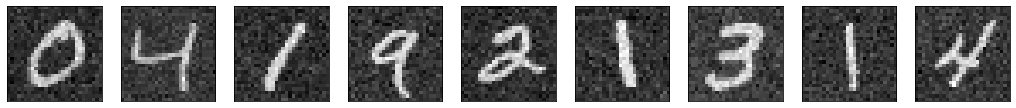

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 27s - loss: 0.7854 - acc: 0.9117 - val_loss: 0.4111 - val_acc: 0.9543
Epoch 2/5
 - 20s - loss: 0.3514 - acc: 0.9548 - val_loss: 0.2814 - val_acc: 0.9655
Epoch 3/5
 - 19s - loss: 0.2838 - acc: 0.9609 - val_loss: 0.2466 - val_acc: 0.9676
Epoch 4/5
 - 19s - loss: 0.2595 - acc: 0.9641 - val_loss: 0.2304 - val_acc: 0.9715
Epoch 5/5
 - 21s - loss: 0.2525 - acc: 0.9641 - val_loss: 0.2469 - val_acc: 0.9636
Test loss: 0.24692589633464812
Test accuracy: 0.9636
Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000
('l2', 0.001)
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_____________________________

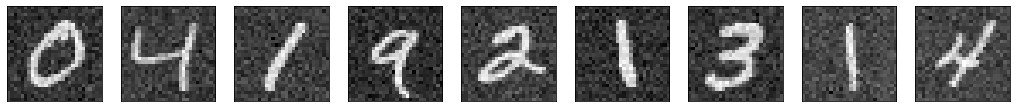

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 29s - loss: 0.9981 - acc: 0.9100 - val_loss: 0.4955 - val_acc: 0.9585
Epoch 2/5
 - 27s - loss: 0.4157 - acc: 0.9538 - val_loss: 0.3257 - val_acc: 0.9611
Epoch 3/5
 - 32s - loss: 0.3236 - acc: 0.9595 - val_loss: 0.2865 - val_acc: 0.9658
Epoch 4/5
 - 31s - loss: 0.2915 - acc: 0.9625 - val_loss: 0.2752 - val_acc: 0.9667
Epoch 5/5
 - 29s - loss: 0.2822 - acc: 0.9634 - val_loss: 0.2664 - val_acc: 0.9669
Test loss: 0.26639586758613587
Test accuracy: 0.9669
Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
___________________________________________

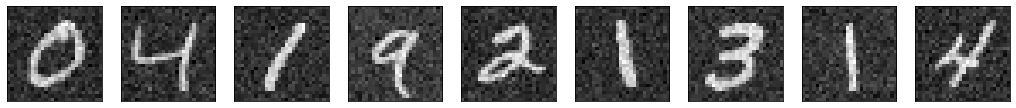

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 22s - loss: 0.9165 - acc: 0.8932 - val_loss: 0.5074 - val_acc: 0.9263
Epoch 2/5
 - 33s - loss: 0.4495 - acc: 0.9267 - val_loss: 0.3647 - val_acc: 0.9390
Epoch 3/5
 - 26s - loss: 0.3692 - acc: 0.9360 - val_loss: 0.3370 - val_acc: 0.9419
Epoch 4/5
 - 23s - loss: 0.3449 - acc: 0.9380 - val_loss: 0.3080 - val_acc: 0.9479
Epoch 5/5
 - 23s - loss: 0.3296 - acc: 0.9409 - val_loss: 0.3006 - val_acc: 0.9492
Test loss: 0.30061237773895266
Test accuracy: 0.9492
Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000
('l2', 0.001)
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_____________________________

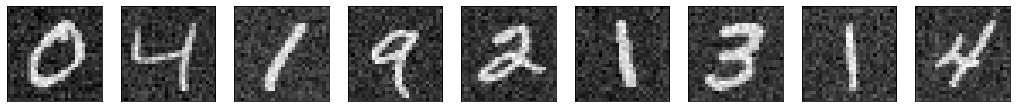

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 31s - loss: 1.2457 - acc: 0.8899 - val_loss: 0.6461 - val_acc: 0.9359
Epoch 2/5
 - 30s - loss: 0.5485 - acc: 0.9253 - val_loss: 0.4351 - val_acc: 0.9345
Epoch 3/5
 - 37s - loss: 0.4176 - acc: 0.9319 - val_loss: 0.3632 - val_acc: 0.9450
Epoch 4/5
 - 34s - loss: 0.3847 - acc: 0.9365 - val_loss: 0.3480 - val_acc: 0.9425
Epoch 5/5
 - 33s - loss: 0.3677 - acc: 0.9377 - val_loss: 0.3388 - val_acc: 0.9468
Test loss: 0.3387694431066513
Test accuracy: 0.9468


In [7]:
history_without_noise = []
i = 0
for layer_activation in combinations:
    model = MyModel(layer_activation, epochs=5)
    model.add_noise()
    model.build_model()
    model.print_head()
    history_without_noise.append(model.train_model())
    model.calculate_accuracy()
    i+=1
    model.save('model{}.h5'.format(i))

In [15]:
print(list(history_with_noise[0].history['val_loss']))

[0.41105857996940615, 0.28141554698944093, 0.24659705891609193, 0.23035530014038086, 0.24692589213848115]


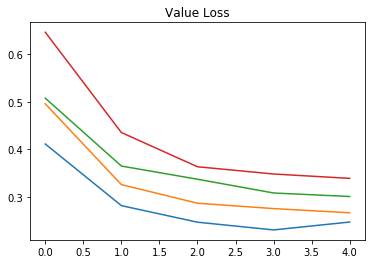

In [26]:
for i in range(len(history_with_noise)):
    plt.plot(history_with_noise[i].history['val_loss'])
    plt.title('Value Loss')
plt.show()

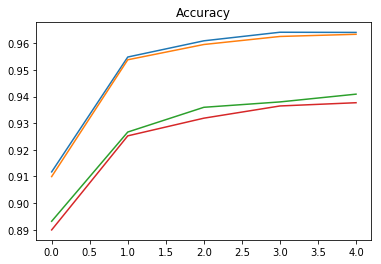

In [24]:
for i in range(len(history_with_noise)):
    plt.plot(history_with_noise[i].history['acc'])
    plt.title('Accuracy')
plt.show()

# Encoder Module

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


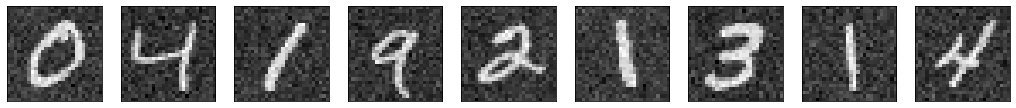

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 17s - loss: 771.5108 - val_loss: 760.4970
Epoch 2/5
 - 10s - loss: 748.1912 - val_loss: 751.0044
Epoch 3/5
 - 10s - loss: 741.0332 - val_loss: 746.0744
Epoch 4/5
 - 10s - loss: 737.7185 - val_loss: 743.7194
Epoch 5/5
 - 11s - loss: 735.8102 - val_loss: 742.3401


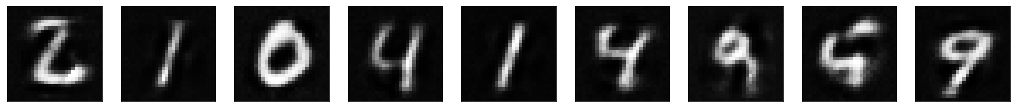

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


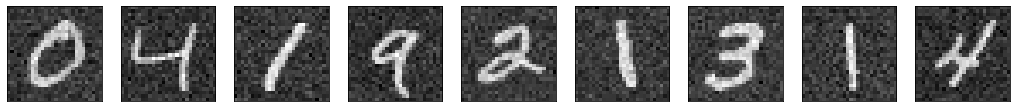

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 15s - loss: 772.4899 - val_loss: 760.7787
Epoch 2/5
 - 13s - loss: 748.4370 - val_loss: 752.0352
Epoch 3/5
 - 13s - loss: 742.7838 - val_loss: 748.3251
Epoch 4/5
 - 13s - loss: 739.9705 - val_loss: 746.3668
Epoch 5/5
 - 10s - loss: 738.5190 - val_loss: 745.3005


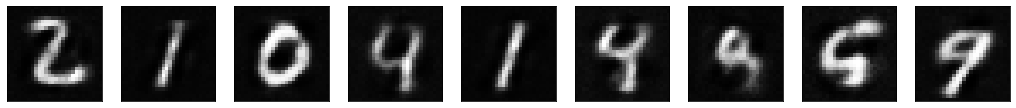

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


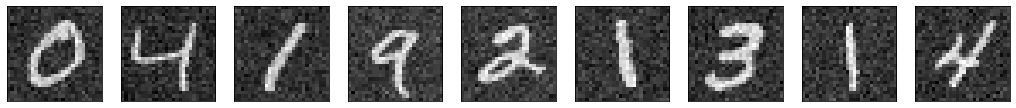

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 14s - loss: 768.1814 - val_loss: 755.9199
Epoch 2/5
 - 11s - loss: 742.2858 - val_loss: 745.5470
Epoch 3/5
 - 11s - loss: 736.6695 - val_loss: 742.8739
Epoch 4/5
 - 11s - loss: 734.4568 - val_loss: 741.1116
Epoch 5/5
 - 11s - loss: 733.1358 - val_loss: 740.3140


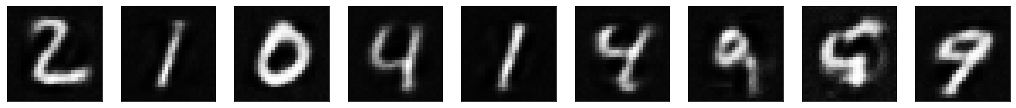

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


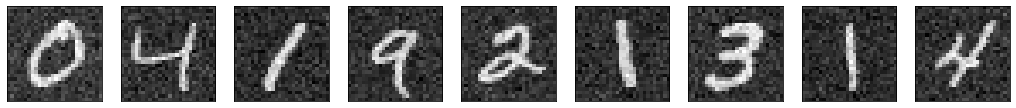

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 13s - loss: 766.2032 - val_loss: 754.4550
Epoch 2/5
 - 11s - loss: 741.3785 - val_loss: 745.1176
Epoch 3/5
 - 11s - loss: 736.1876 - val_loss: 742.1128
Epoch 4/5
 - 11s - loss: 733.9809 - val_loss: 740.5373
Epoch 5/5
 - 11s - loss: 732.7295 - val_loss: 739.5820


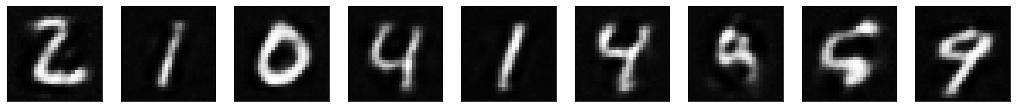

In [48]:
encoder_history = []

image_without_noise_x_train = []

for layer_activation in combinations:
    model = MyModel(layer_activation, epochs=5)
    model.add_noise()
    model.print_head()
    image_with_noise , history = model.create_decoder_model()
    encoder_history.append(history)
    plt.figure(figsize=(20, 4))
    for i in range(1,10):
        ax = plt.subplot(2, 10, i)
        plt.imshow(image_with_noise[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    


Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


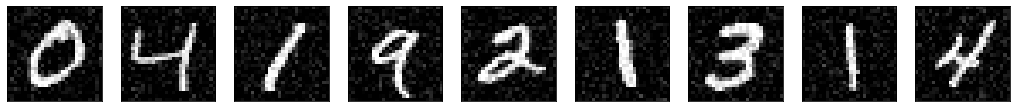

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 14s - loss: 773.4056 - val_loss: 761.4819
Epoch 2/5
 - 11s - loss: 748.6470 - val_loss: 750.8987
Epoch 3/5
 - 12s - loss: 741.5439 - val_loss: 746.8405
Epoch 4/5
 - 12s - loss: 738.7229 - val_loss: 744.7336
Epoch 5/5
 - 14s - loss: 736.9406 - val_loss: 743.1889
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_____________________________________________________

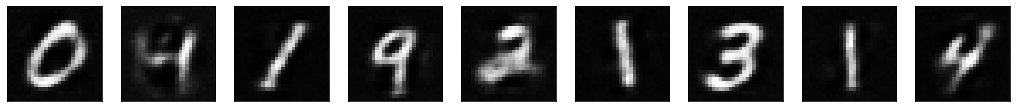

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


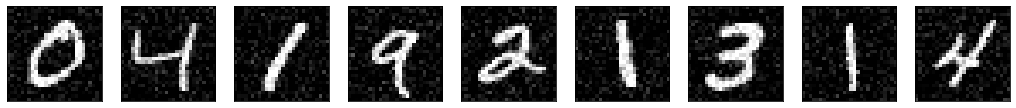

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 15s - loss: 773.1474 - val_loss: 760.8757
Epoch 2/5
 - 11s - loss: 747.7398 - val_loss: 750.4247
Epoch 3/5
 - 10s - loss: 740.8134 - val_loss: 746.3017
Epoch 4/5
 - 11s - loss: 737.9990 - val_loss: 744.4680
Epoch 5/5
 - 11s - loss: 736.4153 - val_loss: 743.0624
('l2', 0.001)
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_______________________________________

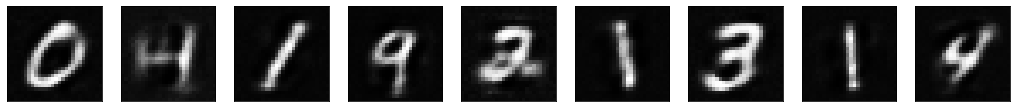

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


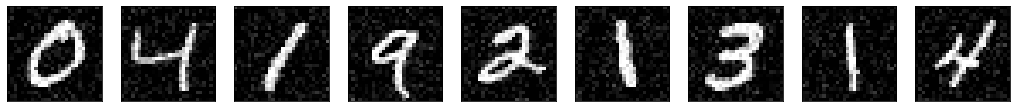

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 15s - loss: 765.1873 - val_loss: 753.6416
Epoch 2/5
 - 13s - loss: 741.7636 - val_loss: 745.6900
Epoch 3/5
 - 16s - loss: 736.7823 - val_loss: 742.6303
Epoch 4/5
 - 16s - loss: 734.7787 - val_loss: 741.4160
Epoch 5/5
 - 12s - loss: 733.7638 - val_loss: 740.5529
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_____________________________________________________

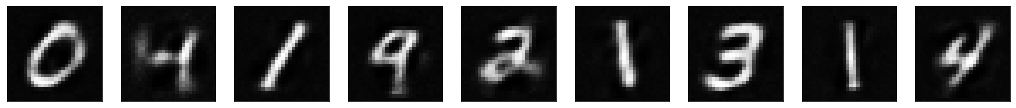

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


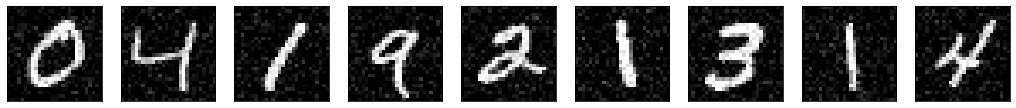

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 25s - loss: 764.7719 - val_loss: 753.5483
Epoch 2/5
 - 13s - loss: 741.5783 - val_loss: 745.1086
Epoch 3/5
 - 15s - loss: 736.3854 - val_loss: 742.1296
Epoch 4/5
 - 14s - loss: 734.2134 - val_loss: 740.5702
Epoch 5/5
 - 12s - loss: 732.8896 - val_loss: 739.4530
('l2', 0.001)
('l2', 0.001)
('l2', 0.001)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_______________________________________

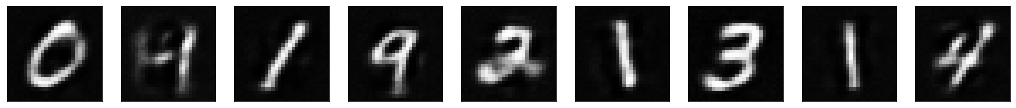

In [52]:
denoised_data = []
denoised_model_history = []

for layer_activation in combinations:
    model = MyModel(layer_activation, epochs=5)
    model.add_noise()
    model.print_head()
    image_with_noise , history = model.create_decoder_model()
    model.build_model()
    denoised_model_history.append(model.train_model())
    model.print_head()
    denoised_data.append(history)
    